# Exploration des occupations et de leur évolution dans le temps 

Dans ce carnet est proposée une exploration des occupations de la population Wikidata retenue.

On essayera de prendre connaissance des liens entre types d'occupation, le genre et les générations

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


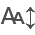

In [4]:
### https://mwouts.github.io/itables/quick_start.html

from itables import init_notebook_mode, show

init_notebook_mode(all_interactive=False)


In [5]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [6]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile


## Explorer les occupations

In [7]:
cn = sql.connect('../../data/astronomers_import.db')

In [8]:
### Le nombre de métiers différents: noter qu'il y des répétitions
## et inconsistances dans les données de Wikidata

q="""
SELECT COUNT(*)
FROM wdt_occupation
"""
cur = cn.cursor()
r = cur.execute(q).fetchone()
print('Nombre de métiers différents:' , r[0])

Nombre de métiers différents: 1246


In [9]:
### Inspecter la table des métiers Wikidata

q="""
SELECT pk_wdt_occupation, label, wdt_uri
FROM wdt_occupation
"""
cur = cn.cursor()
r = cur.execute(q).fetchall()
[e for e in r][:3]

[(1, 'astrologer', 'http://www.wikidata.org/entity/Q155647'),
 (2, 'mathematician', 'http://www.wikidata.org/entity/Q170790'),
 (3, 'university teacher', 'http://www.wikidata.org/entity/Q1622272')]

In [10]:
### Compter les occurrences de chaque métier

q="""
-- noter que la fonction TRIM élimine les éventuels espaces en début ou fin de chaine de charactères
-- la fonction LOWER met tout au minuscule
SELECT TRIM(occupationUri) as occupationUri, LOWER(TRIM(occupationLabel)) AS occupationLabel, COUNT(*) as effectif
FROM wdt_person_occupation
GROUP BY TRIM(occupationUri), LOWER(TRIM(occupationLabel))
ORDER BY effectif DESC
"""
cur = cn.cursor()
r = cur.execute(q).fetchall()
rdf = pd.DataFrame(r,columns=['uri', 'label', 'freq'])
rdf.head()

,uri,label,freq
0,http://www.wikidata.org/entity/Q169470,physicist,25564
1,http://www.wikidata.org/entity/Q11063,astronomer,8054
2,http://www.wikidata.org/entity/Q1622272,university teacher,7423
3,http://www.wikidata.org/entity/Q170790,mathematician,2888
4,http://www.wikidata.org/entity/Q36180,writer,1122


In [11]:
rdf.tail()

,uri,label,freq
1241,http://www.wikidata.org/entity/Q98544732,scientific collector,1
1242,http://www.wikidata.org/entity/Q98594162,moral theologian,1
1243,http://www.wikidata.org/entity/Q98668847,geohasher,1
1244,http://www.wikidata.org/entity/Q99761949,anti-racist,1
1245,http://www.wikidata.org/entity/Q998628,illuminator,1


In [12]:
### On observe une très grande dispersion: comment traiter ce problème?

rdf['freq'].describe()

count     1246.000000
mean        54.243178
std        795.884625
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max      25564.000000
Name: freq, dtype: float64

In [13]:
### On transforme en DataFrame le résultat du regroupement par fréquence:
# combien de fois un certain nombre d'occurrences ? 

q="""
WITH tw1 AS (
SELECT LOWER(TRIM(occupationLabel)) occupationLabel, COUNT(*) as effectif
FROM wdt_person_occupation
GROUP BY TRIM(occupationUri), LOWER(TRIM(occupationLabel)) )
SELECT effectif, count(*) as nombre_occ, group_concat(occupationLabel, '; ')
FROM tw1
GROUP BY effectif
ORDER BY nombre_occ DESC, effectif ASC;
"""
cur = cn.cursor()
r = cur.execute(q).fetchall()

## La colonne 'occurrences' indique le nombre de mentions d'un métier,
# la colonne'nombre_occ' combien de métiers ont cette occurrence
dfr = pd.DataFrame(r, columns=['occurrences','nombre_occ', 'labels_occ'])

# Par exemple, la première ligne indique qu'il y a 573 métiers mentionnées une seule fois
dfr.head()

,occurrences,nombre_occ,labels_occ
0,1,573,buddhologist; science teacher; knight; physica...
1,2,172,crime fiction writer; tour guide; chemistry te...
2,3,81,civil rights advocate; computer engineer; muse...
3,4,60,applied mathematician; bibliographer; electron...
4,6,33,television actor; historian of astronomy; holo...


In [14]:
### Les métiers les plus fréquents
dfr.tail()

,occurrences,nombre_occ,labels_occ
106,1122,1,writer
107,2888,1,mathematician
108,7423,1,university teacher
109,8054,1,astronomer
110,25564,1,physicist


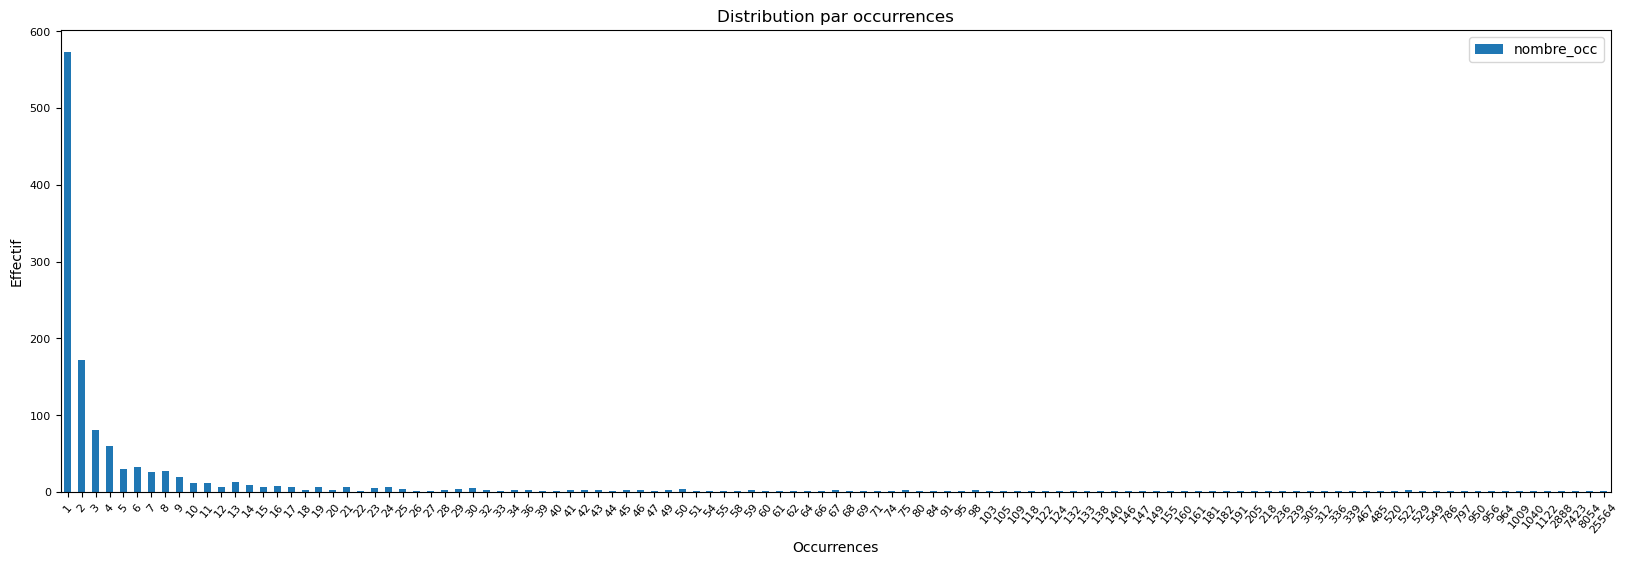

In [20]:
### Représentation graphique des effectifs par occurrences

ax = dfr.sort_values(by='occurrences', ascending=True).plot(x='occurrences', y='nombre_occ', 
                 kind='bar', fontsize=8, figsize=(20,6), rot=50) # ,rot=5


plt.ylabel('Effectif')
plt.xlabel('Occurrences')
plt.title('Distribution par occurrences')
plt.show()

In [21]:
dfr['occ_qcut'] = pd.qcut(dfr['occurrences'], 10)
dfr['occ_qcut']  = dfr['occ_qcut'] .apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)))

dfr.head()

,occurrences,nombre_occ,labels_occ,occ_qcut
0,1,573,buddhologist; science teacher; knight; physica...,0-12
1,2,172,crime fiction writer; tour guide; chemistry te...,0-12
2,3,81,civil rights advocate; computer engineer; muse...,0-12
3,4,60,applied mathematician; bibliographer; electron...,0-12
4,6,33,television actor; historian of astronomy; holo...,0-12


In [25]:
dfrg = dfr.groupby(by='occ_qcut', observed=True).sum(['occurrences','nombre_occ'])
dfrg

,occurrences,nombre_occ
occ_qcut,,
0-12,78,1053
12-23,198,67
23-36,324,32
36-50,486,21
50-67,657,14
67-103,908,14
103-147,1414,11
147-239,2077,11
239-786,5150,12


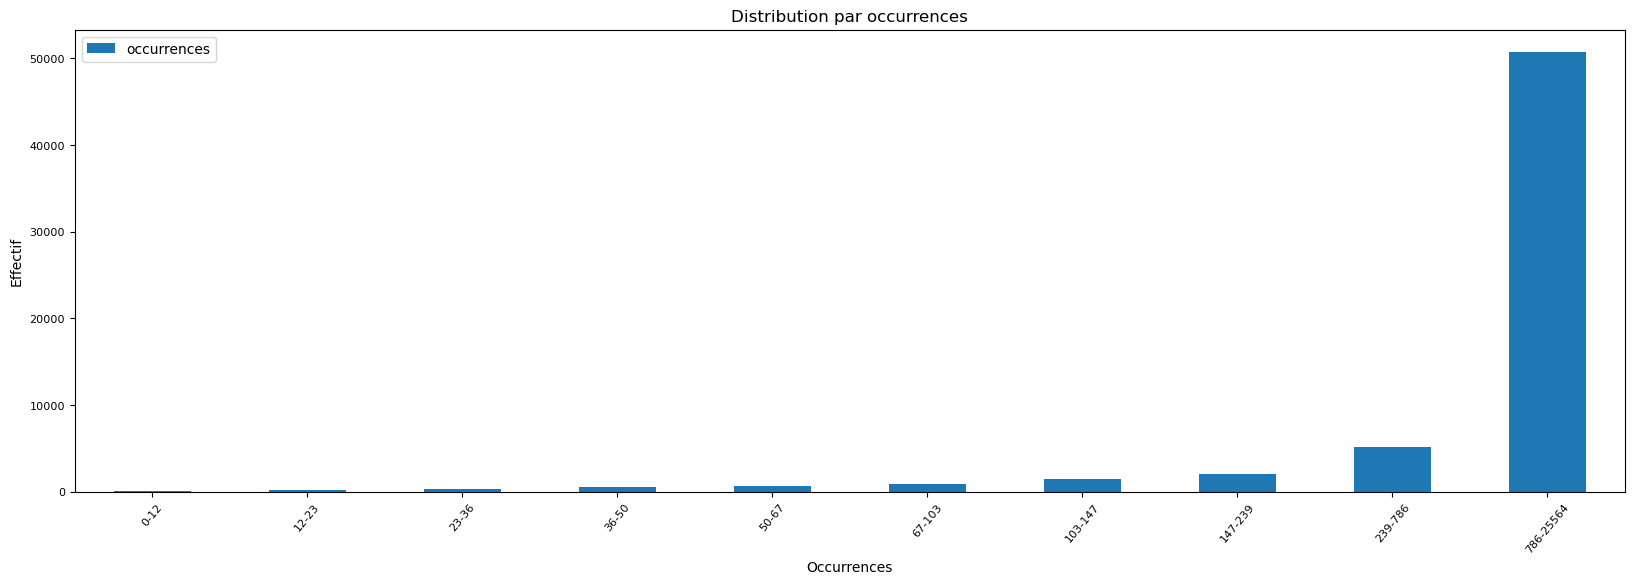

In [46]:
### Représentation graphique des effectifs par occurrences

ax = dfrg.sort_values(by='occurrences', ascending=True).plot( y='occurrences', 
                 kind='bar', fontsize=8, figsize=(20,6), rot=50) # ,rot=5


plt.ylabel('Effectif')
plt.xlabel('Occurrences')
plt.title('Distribution par occurrences')
plt.show()

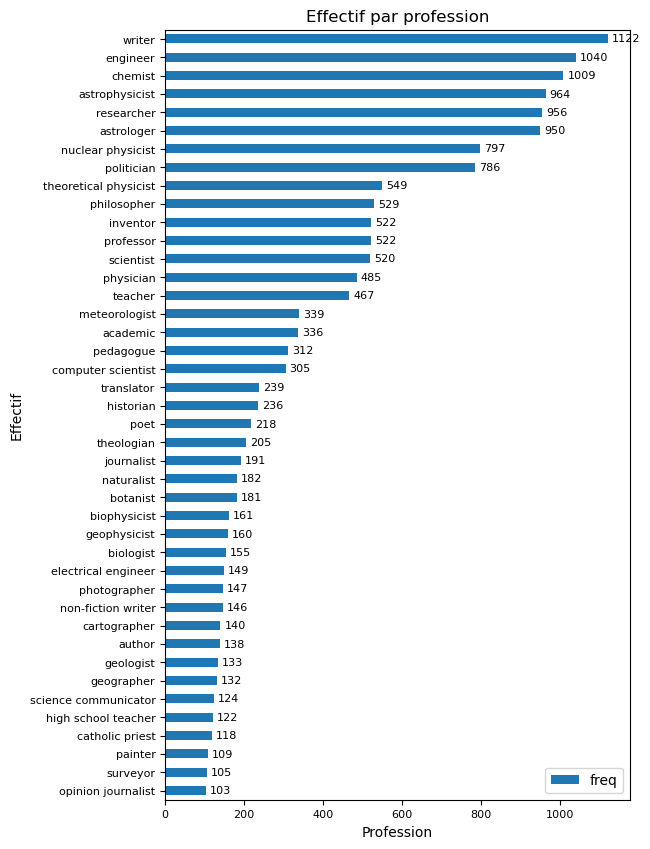

In [49]:
### Représentation graphique des effectifs par profession

# ATTENTION : noter les filtres sur les effectifs
ax = rdf[(rdf['freq']>100) & (rdf['freq'] < 2000)].sort_values(by='freq', ascending=True).plot(x='label', y='freq', 
                 kind='barh', fontsize=8, figsize=(6, 10)) # ,rot=5


#max_xticks = 20
#xloc = plt.MaxNLocator(max_xticks)
#ax.xaxis.set_major_locator(xloc)

x = rdf[(rdf['freq']>100) & (rdf['freq'] < 2000)]['freq'].sort_values(ascending=True).to_list()
for i, v in enumerate(x):
    ax.text(v + 10, i, str(v), color='black', fontsize=8, verticalalignment='center')


plt.ylabel('Effectif')
plt.xlabel('Profession')
plt.title('Effectif par profession')
plt.show()

## Explorer les personnes en relation avec leurs métiers

In [51]:
### Créer la requête SQL et inspecter le résultat
# Noter les jointures entre les différentes tables

q="""
SELECT wp.personUri, wp.personLabel, min(wp.genderUri) gender, 
			min(wp.birthYear) birthYear, 
			group_concat(distinct trim(occupationLabel) order by occupationLabel) occupationLabels
FROM wdt_person_occupation wpo, wdt_personne wp 
WHERE wp.personUri = wpo.personUri 
GROUP BY wp.personUri, wp.personLabel;
"""
cur = cn.cursor()
r = cur.execute(q).fetchall()
[e for e in r][:3]

[('http://www.wikidata.org/entity/Q1000193',
  'Hans Elsässer',
  'http://www.wikidata.org/entity/Q6581097',
  '1929',
  'astronomer'),
 ('http://www.wikidata.org/entity/Q1000934',
  'Charles Christian Lauritsen',
  'http://www.wikidata.org/entity/Q6581097',
  '1892',
  'nuclear physicist,physicist,university teacher'),
 ('http://www.wikidata.org/entity/Q100153910',
  'Frank J. Blatt',
  'http://www.wikidata.org/entity/Q6581097',
  '1924',
  'physicist,university teacher')]

### Créer le tableau à analyser

In [54]:
### On transforme la liste en DataFrame

df_p = pd.DataFrame(r, columns=['person_uri', 'person_label', 
                        'genderUri', 'birthYear', 'occupations'])
df_p = df_p.set_index('person_uri',drop=True)



### On ajoute une nouvelle colonne avec les métiers sous forme de liste
df_p['l_occupations'] = df_p.apply(lambda x: x['occupations'].split(','), axis=1)

### On ajoute une nouvelle colonne avec le nombre de composantes de la liste
df_p['length_l_occ'] = df_p.apply(lambda x: len(x['l_occupations']), axis=1)

## on pourrait éliminer la colonne originale
# mais on la laisse car utile pour les filtres
## df_p = df_p.drop(columns=['occupations'])

df_p.head()

,person_label,genderUri,birthYear,occupations,l_occupations,length_l_occ
person_uri,,,,,,
http://www.wikidata.org/entity/Q1000193,Hans Elsässer,http://www.wikidata.org/entity/Q6581097,1929,astronomer,[astronomer],1
http://www.wikidata.org/entity/Q1000934,Charles Christian Lauritsen,http://www.wikidata.org/entity/Q6581097,1892,"nuclear physicist,physicist,university teacher","[nuclear physicist, physicist, university teac...",3
http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,http://www.wikidata.org/entity/Q6581097,1924,"physicist,university teacher","[physicist, university teacher]",2
http://www.wikidata.org/entity/Q100155322,Edgar Knobloch,http://www.wikidata.org/entity/Q6581097,1953,physicist,[physicist],1
http://www.wikidata.org/entity/Q100157315,Ding Jing,http://www.wikidata.org/entity/Q6581097,1924,"physicist,university teacher","[physicist, university teacher]",2


In [55]:
print(len(df_p))

32908


### Coder le genre

In [56]:
### On créé d'abord une fonction qui effectue le travail

## l'argument de la fonction 'g_uri' est un nom choisi librement
# il est ensuite appelé dans la fonction comme variable
# et contient la valeur introduite lors de l'utilisation de la fonction 
def code_gender(g_uri):
    if g_uri == 'http://www.wikidata.org/entity/Q6581097':
        # genre masculin
        a = 'M'
    elif g_uri =='http://www.wikidata.org/entity/Q6581072':
        # genre féminin
        a = 'F'
    else:
        # genre autre
        a = 'A'
    return a    

In [57]:
### On ajoute une nouvelle colonne et y on met pour chaque ligne le résultat de la fonction
df_p['gender'] = df_p.apply(lambda x: code_gender(x['genderUri']), axis=1)

## on élimine la colonne originale 
df_p = df_p.drop(columns=['genderUri'])
### On inspecte les cinq premières lignes qui ont la valeur 'A' = autre
df_p[df_p['gender']=='A'][:5]

,person_label,birthYear,occupations,l_occupations,length_l_occ,gender
person_uri,,,,,,
http://www.wikidata.org/entity/Q124414761,JA Grier,1968,"astronomer,planetary scientist,scientist","[astronomer, planetary scientist, scientist]",3,A
http://www.wikidata.org/entity/Q125054679,Zhao Wenjin,1991,physicist,[physicist],1,A
http://www.wikidata.org/entity/Q15990211,Rachael Padman,1954,"astronomer,astrophysicist,physicist","[astronomer, astrophysicist, physicist]",3,A
http://www.wikidata.org/entity/Q16913156,Ophelia Pastrana,1982,"YouTuber,actor,businessperson,physicist,televi...","[YouTuber, actor, businessperson, physicist, t...",5,A
http://www.wikidata.org/entity/Q23656158,Lucianne M. Walkowicz,1979,astronomer,[astronomer],1,A


In [58]:
### Effectifs par genre
df_p.groupby(by='gender', observed=True).size()

gender
A       13
F     2789
M    30106
dtype: int64

### Ajouter les périodes

In [59]:
### Préparer les données

# transformer l'année en entier
df_p['birthYear'] = df_p['birthYear'].astype(int)
# limiter aux personnes nées avant le 21e siècle
df_p = df_p[df_p['birthYear'] < 2001].copy(deep=True)
# vérifier année minimale et maximale
print(min(df_p['birthYear']),max(df_p['birthYear']))

1355 2000


In [60]:
### Créer six périodes
l_per = [1351, 1501, 1601, 1701, 1801, 1921, 2001]

In [61]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_p['periodes'] = pd.cut(df_p['birthYear'], l_per, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['periodes'] = df_p['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.head(3)

,person_label,birthYear,occupations,l_occupations,length_l_occ,gender,periodes
person_uri,,,,,,,
http://www.wikidata.org/entity/Q1000193,Hans Elsässer,1929,astronomer,[astronomer],1,M,1921-2000
http://www.wikidata.org/entity/Q1000934,Charles Christian Lauritsen,1892,"nuclear physicist,physicist,university teacher","[nuclear physicist, physicist, university teac...",3,M,1801-1920
http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,1924,"physicist,university teacher","[physicist, university teacher]",2,M,1921-2000


In [62]:
### Effectifs par période
df_p.groupby(by='periodes', observed=True).size()

periodes
1351-1500      221
1501-1600      476
1601-1700      593
1701-1800     1372
1801-1920     9484
1921-2000    20677
dtype: int64

## Distribution des combinaisons de métiers

In [63]:
df_p.head(2)

,person_label,birthYear,occupations,l_occupations,length_l_occ,gender,periodes
person_uri,,,,,,,
http://www.wikidata.org/entity/Q1000193,Hans Elsässer,1929,astronomer,[astronomer],1,M,1921-2000
http://www.wikidata.org/entity/Q1000934,Charles Christian Lauritsen,1892,"nuclear physicist,physicist,university teacher","[nuclear physicist, physicist, university teac...",3,M,1801-1920


In [64]:
### Compter les effectifs par combinaison de professions
combinaisons = pd.DataFrame(df_p.groupby(by='occupations', observed=True).size()\
                            .sort_values(ascending=False),
                             columns=['effectif'])
combinaisons.reset_index(drop=False, inplace=True)
combinaisons['l_occupations'] = combinaisons.apply(lambda x: x['occupations'].split(','), axis=1)
combinaisons['length_l_occ'] = combinaisons.apply(lambda x: len(x['l_occupations']), axis=1)
combinaisons.head()

,occupations,effectif,l_occupations,length_l_occ
0,physicist,11012,[physicist],1
1,astronomer,3345,[astronomer],1
2,"physicist,university teacher",3030,"[physicist, university teacher]",2
3,"mathematician,physicist",471,"[mathematician, physicist]",2
4,"physicist,researcher",428,"[physicist, researcher]",2


In [67]:
combinaisons.sort_values(by='length_l_occ', ascending=False).head()

,occupations,effectif,l_occupations,length_l_occ
5072,"aphorist,art critic,art historian,art theorist...",1,"[aphorist, art critic, art historian, art theo...",31
3428,"astronomer,botanical collector,botanist,chambe...",1,"[astronomer, botanical collector, botanist, ch...",26
2359,"Dungeon Master,Magic: The Gathering player,Wik...",1,"[Dungeon Master, Magic: The Gathering player, ...",23
5434,"anatomist,architect,architectural draftsperson...",1,"[anatomist, architect, architectural draftsper...",23
4220,"archivist,biologist,diplomat,diplomatician,eng...",1,"[archivist, biologist, diplomat, diplomatician...",21


In [68]:
## Noter que ce sont les trois métiers qui sont à la base de la requête SPARQL

combinaisons[(combinaisons['length_l_occ'] == 1) ] 

,occupations,effectif,l_occupations,length_l_occ
0,physicist,11012,[physicist],1
1,astronomer,3345,[astronomer],1
11,astrologer,262,[astrologer],1


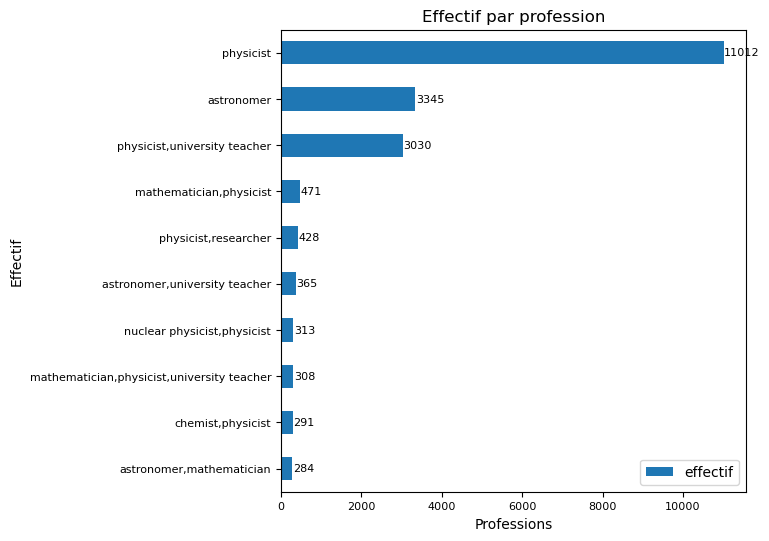

In [71]:
### Représentation graphique des effectifs par profession
# noter la prédominance de certaines modalités

# ATTENTION : noter les filtres sur les effectifs
ax = combinaisons[:10].sort_values(by='effectif', ascending=True).plot(x='occupations', y='effectif', 
                 kind='barh', fontsize=8, figsize=(6, 6)) # ,rot=5
# .sort_values(by='freq', ascending=True)

#max_xticks = 20
#xloc = plt.MaxNLocator(max_xticks)
#ax.xaxis.set_major_locator(xloc)

x = combinaisons[:10].sort_values(by='effectif',ascending=True)['effectif'].to_list()
for i, v in enumerate(x):
    ax.text(v + 10, i, str(v), color='black', fontsize=8, verticalalignment='center')


plt.ylabel('Effectif')
plt.xlabel('Professions')
plt.title('Effectif par profession')
plt.show()

In [ ]:
show(combinaisons[['effectif', 'length_l_occ', 'occupations']],  scrollY="300px",
     scrollCollapse=True, paging=False, layout={"topEnd": None}, 
     showIndex=False, column_filters="header", columnDefs=[{"className": "dt-left", "targets": "_all"}],
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0)

In [73]:
c_plus_que_1 = combinaisons[combinaisons['length_l_occ'] > 1]
c_plus_que_1['effectif'].describe()

count    5501.000000
mean        3.309217
std        43.961630
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      3030.000000
Name: effectif, dtype: float64

count    913.000000
mean       4.081051
std        3.308018
min        2.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       19.000000
Name: effectif, dtype: float64


/tmp/ipykernel_22737/141074161.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfc = c_plus_que_1[(c_plus_que_1['effectif'] > 1) & (combinaisons['effectif'] < 20)]


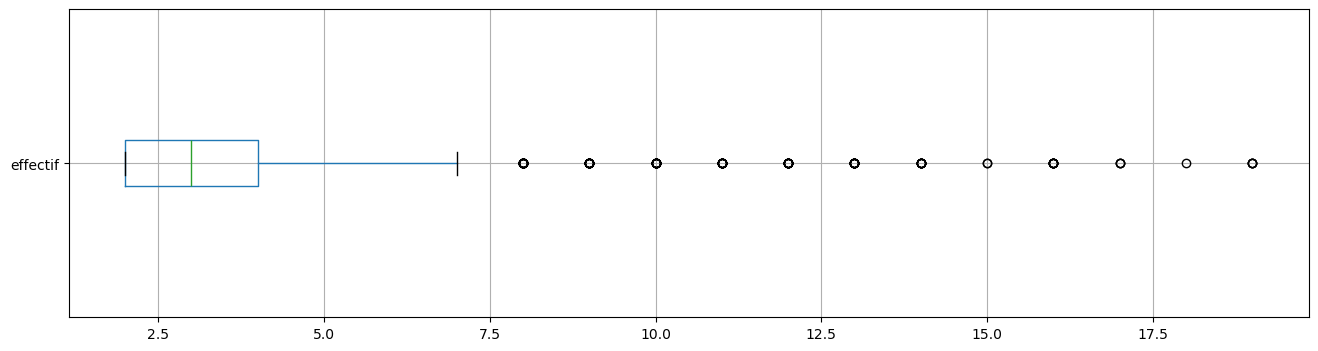

In [75]:
### 
dfc = c_plus_que_1[(c_plus_que_1['effectif'] > 1) & (combinaisons['effectif'] < 20)]
print(dfc['effectif'].describe())

dfc.boxplot(column=['effectif'], vert=False, figsize=(16,4))
plt.show()


count     67.000000
mean     106.447761
std      109.221249
min       21.000000
25%       29.500000
50%       52.000000
75%      145.500000
max      471.000000
Name: effectif, dtype: float64


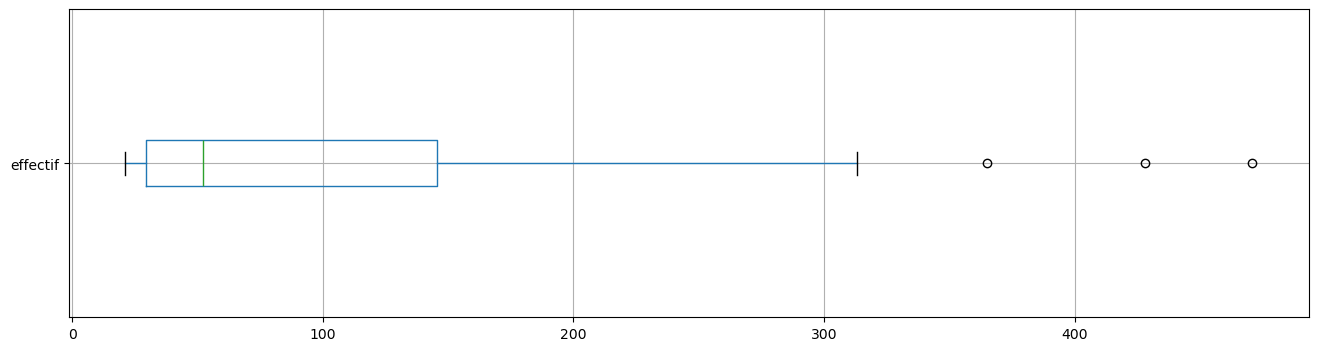

In [76]:
### 

dfc = combinaisons[(combinaisons['effectif'] > 20) & (combinaisons['effectif'] < 1000)]
print(dfc['effectif'].describe())

dfc.boxplot(column=['effectif'], vert=False, figsize=(16,4))
plt.show()


In [77]:
## Compter les effectifs par nombre de composantes
c_eff = combinaisons.groupby(by='length_l_occ').size().sort_values(ascending=False)
c_eff.head()

length_l_occ
3    1671
4    1456
5     804
2     707
6     421
dtype: int64

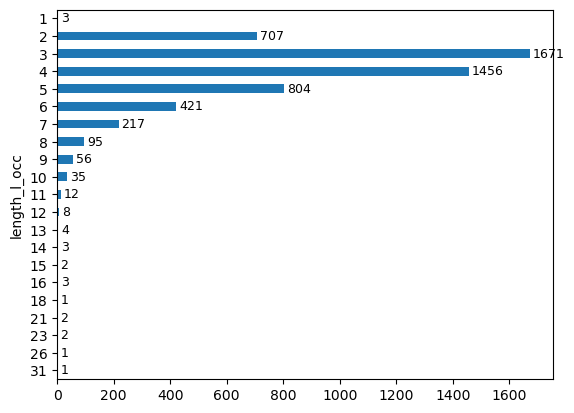

In [78]:
ax = c_eff.sort_index(ascending=False).plot(kind='barh')
x = c_eff.sort_index(ascending=False).to_list()
for i, v in enumerate(x):
    ax.text(v + 10, i, str(v), color='black', fontsize=9, verticalalignment='center')
plt.show()

In [79]:
show(combinaisons[['effectif', 'length_l_occ', 'occupations']][combinaisons['effectif'] < 10], 
    scrollY="300px",
     scrollCollapse=True, paging=False, 
     showIndex=False, column_filters="header", columnDefs=[{"className": "dt-left", "targets": "_all"}],
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0)

Loading... (need help?)


In [80]:
combinaisons[combinaisons['length_l_occ'] == 12]

,occupations,effectif,l_occupations,length_l_occ
1377,"academic,astronomer,astrophysicist,cosmologist...",1,"[academic, astronomer, astrophysicist, cosmolo...",12
1550,"actor,archaeologist,art director,astrologer,co...",1,"[actor, archaeologist, art director, astrologe...",12
2231,"Catholic vocation,astronomer,diplomat,geograph...",1,"[Catholic vocation, astronomer, diplomat, geog...",12
2500,"Catholic bishop,Catholic priest,Christian mini...",1,"[Catholic bishop, Catholic priest, Christian m...",12
3060,"Hebraist,Protestant reformer,astronomer,cartog...",1,"[Hebraist, Protestant reformer, astronomer, ca...",12
3792,"astronomer,encyclopédistes,engineer,intellectu...",1,"[astronomer, encyclopédistes, engineer, intell...",12
4010,"astrologer,astronomer,cosmologist,mathematicia...",1,"[astrologer, astronomer, cosmologist, mathemat...",12
5285,"amateur astronomer,astronomer,churchwarden,epi...",1,"[amateur astronomer, astronomer, churchwarden,...",12


In [81]:
### Compter les effectifs par combinaison de professions
combinaisons_per = pd.DataFrame(df_p.groupby(by=['occupations','periodes'], observed=True).size()\
                            .sort_values(ascending=False),
                             columns=['effectif'])
combinaisons_per.reset_index(drop=False, inplace=True)
combinaisons_per['l_occupations'] = combinaisons_per.apply(lambda x: x['occupations'].split(','), axis=1)
combinaisons_per['length_l_occ'] = combinaisons_per.apply(lambda x: len(x['l_occupations']), axis=1)
combinaisons_per.head()

,occupations,periodes,effectif,l_occupations,length_l_occ
0,physicist,1921-2000,8296,[physicist],1
1,physicist,1801-1920,2587,[physicist],1
2,"physicist,university teacher",1921-2000,2214,"[physicist, university teacher]",2
3,astronomer,1921-2000,1764,[astronomer],1
4,astronomer,1801-1920,1240,[astronomer],1


In [82]:
tickers = combinaisons_per.groupby(by='periodes', observed=True).size().index.to_list()
tickers

['1351-1500', '1501-1600', '1601-1700', '1701-1800', '1801-1920', '1921-2000']

In [83]:
df = combinaisons_per[combinaisons_per["periodes"] == '1601-1700'].sort_values(by='effectif', ascending=False)[:10][['occupations','effectif']]
df.head() 

,occupations,effectif
35,astronomer,76
51,"astronomer,mathematician",46
96,physicist,18
98,astrologer,17
142,"astronomer,mathematician,university teacher",11


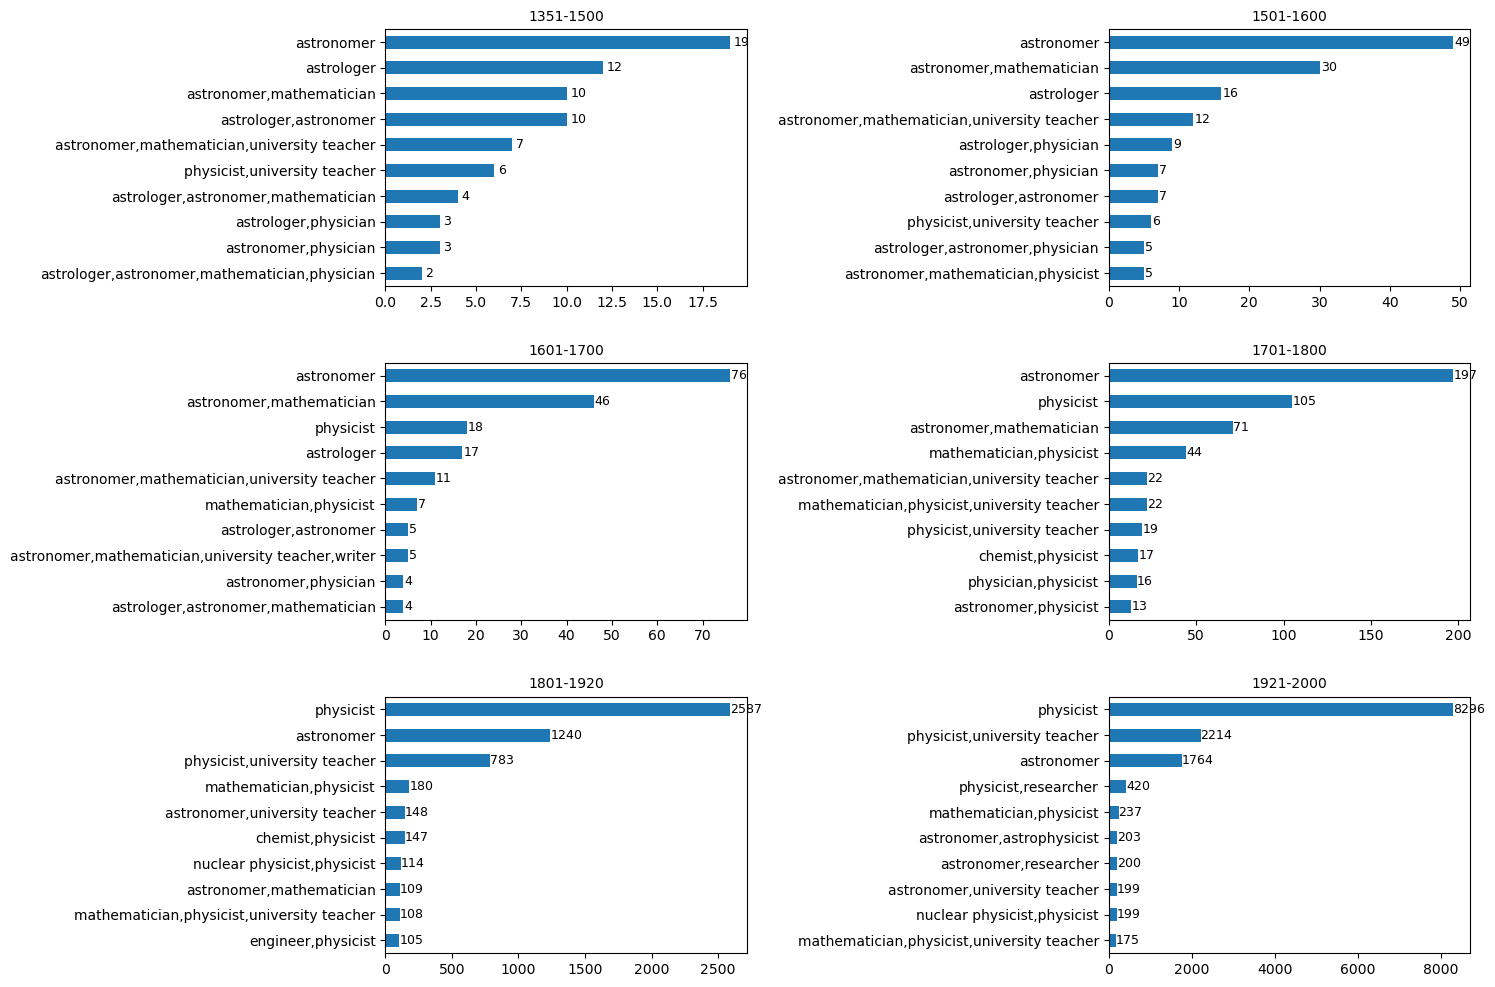

In [305]:
# define subplot grid
fig, axs = plt.subplots(nrows=3, ncols=2,figsize=(200,100) )
plt.subplots_adjust(hspace=0.3, wspace=1)
#fig.suptitle("Daily closing prices", fontsize=18, y=0.95)

# loop through tickers and axes
for ticker, ax in zip(tickers, axs.ravel()):
    df = combinaisons_per[combinaisons_per["periodes"] == ticker].sort_values(by='effectif', ascending=False)[:10][['occupations','effectif']]


    df.sort_values(by='effectif', ascending=True).plot(ax=ax, x='occupations', y='effectif', 
                    kind='barh', fontsize=10, figsize=(14,12)) # ,rot=5
    # .sort_values(by='freq', ascending=True)

    #max_xticks = 20
    #xloc = plt.MaxNLocator(max_xticks)
    #ax.xaxis.set_major_locator(xloc)

    x = df.sort_values(by='effectif', ascending=True)['effectif'].to_list()
    for i, v in enumerate(x):
        ax.text(v + 0.2, i, str(v), color='black', fontsize=9, verticalalignment='center')


    ax.set_ylabel("")    



    # chart formatting
    ax.set_title(ticker.upper(), fontsize=10)
    ax.get_legend().remove()
    ax.set_xlabel("")

plt.show()


## Market Basket Analysis: la carte Cumulus appliquée aux professions

In [86]:
### Distribution par périodes
gp = df_p[df_p['length_l_occ']> 1].groupby(by=['periodes'], observed=True).size()
gp

periodes
1351-1500      189
1501-1600      406
1601-1700      482
1701-1800     1066
1801-1920     5601
1921-2000    10460
dtype: int64

In [87]:
gp.index.to_list()

['1351-1500', '1501-1600', '1601-1700', '1701-1800', '1801-1920', '1921-2000']

In [92]:
### Esplorer par périodes

# l'ensemble
dd = df_p[df_p['length_l_occ']> 1]

#dd = df_p[(df_p['periodes']=='1501-1600') & (df_p['length_l_occ']> 1)]
#dd = df_p[(df_p['periodes']=='1351-1500') & (df_p['length_l_occ']> 1)]
#dd = df_p[(df_p['periodes']=='1921-2000') & (df_p['length_l_occ']> 1)]
#dd = df_p[(df_p['periodes']=='1801-1920') & (df_p['length_l_occ']> 1)]


In [96]:
te = TransactionEncoder()
## on cherche les combinaisons, on exclut donc les trois disciplines seules
te_ary = te.fit_transform(dd[dd['length_l_occ'] > 1]['l_occupations'])
data_df=pd.DataFrame(te_ary, columns=te.columns_)
# data_df.head()

In [ ]:
frequent_itemsets = apriori(data_df, min_support= 0.0099, use_colnames=True)
frequent_itemsets['eff'] = frequent_itemsets['itemsets'].apply(lambda x : len(x))
frequent_itemsets['l_itemsets'] = frequent_itemsets['itemsets'].apply(lambda x : sorted(list(x)))
show(frequent_itemsets[['support', 'eff', 'itemsets']].sort_values(by='support', ascending=False), 
    scrollY="300px",
     scrollCollapse=True, paging=False, layout={"topEnd": None}, 
     showIndex=False, column_filters="header", columnDefs=[{"className": "dt-left", "targets": "_all"}],
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0)


In [129]:
ar = association_rules(frequent_itemsets, min_threshold=0.0 \
                 ).drop('conviction', axis=1).reset_index(drop=True)

print(len(ar))
ar.sort_values(by='lift', ascending=False).head(10)

138


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,zhangs_metric
79,"(university teacher, astronomer)",(astrophysicist),0.052103,0.074665,0.019981,0.383486,5.136064,0.016091,0.849563
82,(astrophysicist),"(university teacher, astronomer)",0.074665,0.052103,0.019981,0.267606,5.136064,0.016091,0.870278
73,"(physicist, astronomer)",(astrophysicist),0.043977,0.074665,0.016157,0.367391,4.920503,0.012873,0.833420
76,(astrophysicist),"(physicist, astronomer)",0.074665,0.043977,0.016157,0.216389,4.920503,0.012873,0.861060
78,"(university teacher, astrophysicist)",(astronomer),0.026482,0.173709,0.019981,0.754513,4.343534,0.015381,0.790712
83,(astronomer),"(university teacher, astrophysicist)",0.173709,0.026482,0.019981,0.115025,4.343534,0.015381,0.931600
5,(astronomer),(astrophysicist),0.173709,0.074665,0.054685,0.314805,4.216205,0.041714,0.923186
4,(astrophysicist),(astronomer),0.074665,0.173709,0.054685,0.732394,4.216205,0.041714,0.824372
72,"(physicist, astrophysicist)",(astronomer),0.036138,0.173709,0.016157,0.447090,2.573781,0.009879,0.634392
77,(astronomer),"(physicist, astrophysicist)",0.173709,0.036138,0.016157,0.093010,2.573781,0.009879,0.740014


In [ ]:
show(ar.sort_values(by='lift', ascending=False), 
    scrollY="300px",
     scrollCollapse=True, paging=False, layout={"topEnd": None}, 
     showIndex=False, column_filters="header", columnDefs=[{"className": "dt-left", "targets": "_all"}],
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0)

In [ ]:
show(dd, 
    scrollY="300px",
     scrollCollapse=True, paging=False, layout={"topEnd": None}, 
     showIndex=False, column_filters="header", columnDefs=[{"className": "dt-left", "targets": "_all"}],
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0
       )

## Variation de règles en fonction du temps

In [110]:
tickers = combinaisons_per.groupby(by='periodes', observed=True).size().index.to_list()
tickers

['1351-1500', '1501-1600', '1601-1700', '1701-1800', '1801-1920', '1921-2000']

In [111]:
### Esplorer par périodes

# l'ensemble
dd = df_p[df_p['length_l_occ']> 1]

dd = df_p[(df_p['periodes']=='1501-1600') & (df_p['length_l_occ']> 1)]
#dd = df_p[(df_p['periodes']=='1351-1500') & (df_p['length_l_occ']> 1)]
#dd = df_p[(df_p['periodes']=='1921-2000') & (df_p['length_l_occ']> 1)]
#dd = df_p[(df_p['periodes']=='1801-1920') & (df_p['length_l_occ']> 1)]


In [117]:
te = TransactionEncoder()
## on cherche les combinaisons, on exclut donc les trois disciplines seules
te_ary = te.fit_transform(dd[dd['length_l_occ'] > 1]['l_occupations'])
data_df=pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(data_df, min_support= 0.0099, use_colnames=True)
frequent_itemsets['eff'] = frequent_itemsets['itemsets'].apply(lambda x : len(x))
frequent_itemsets['l_itemsets'] = frequent_itemsets['itemsets'].apply(lambda x : sorted(list(x)))
frequent_itemsets[['itemsets', 'support']].sort_values(by='support', ascending=False)[:10]

,itemsets,support
4,(astronomer),0.716749
17,(mathematician),0.554187
68,"(mathematician, astronomer)",0.472906
3,(astrologer),0.280788
25,(physician),0.266010
26,(physicist),0.229064
36,(university teacher),0.229064
24,(philosopher),0.167488
85,"(university teacher, astronomer)",0.152709
127,"(university teacher, mathematician)",0.152709


### Représentation du support

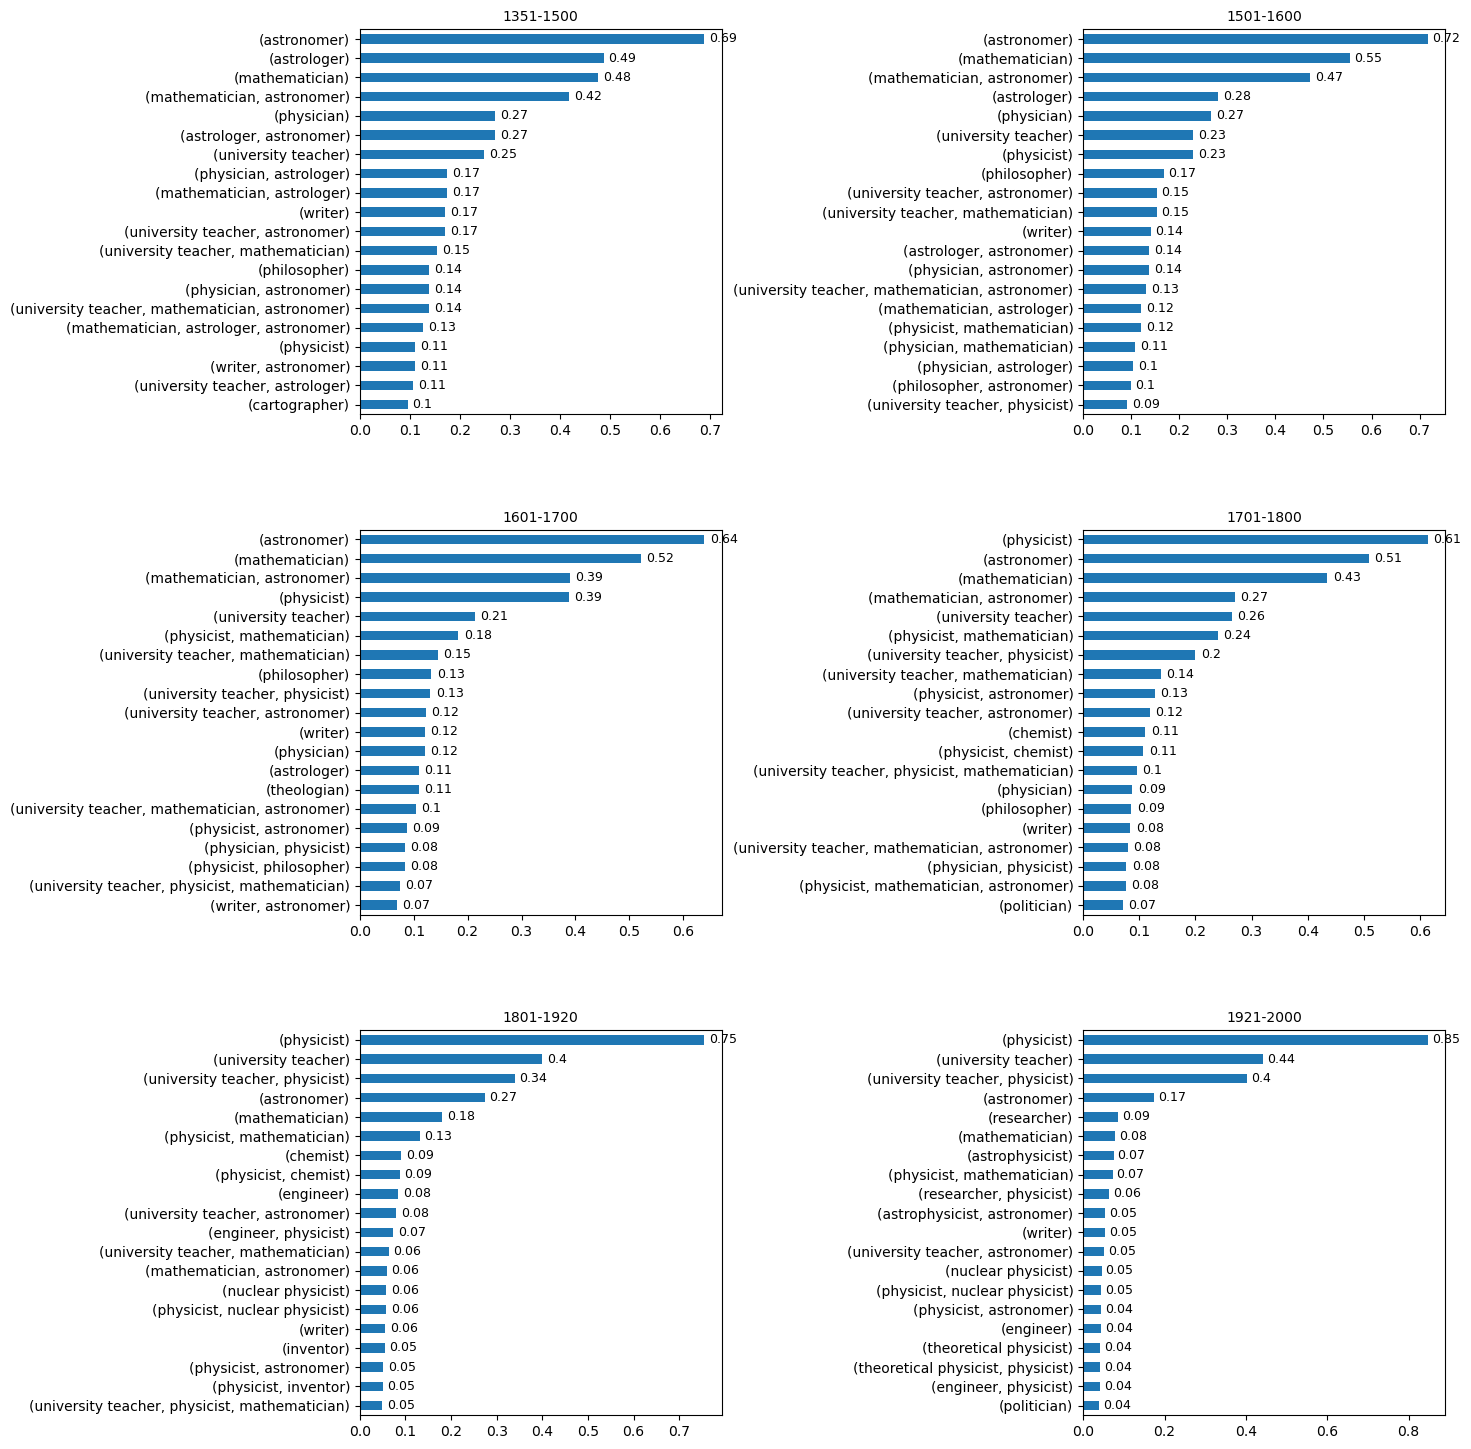

In [122]:
# define subplot grid
fig, axs = plt.subplots(nrows=3, ncols=2,figsize=(200,100) )
plt.subplots_adjust(hspace=0.3, wspace=1)

# loop through tickers and axes
for ticker, ax in zip(tickers, axs.ravel()):
    dd = df_p[(df_p['periodes']==ticker) & (df_p['length_l_occ']> 1)]
    te = TransactionEncoder()
    ## on cherche les combinaisons, on exclut donc les trois disciplines seules
    te_ary = te.fit_transform(dd['l_occupations'])
    data_df=pd.DataFrame(te_ary, columns=te.columns_)
    frequent_itemsets = apriori(data_df, min_support= 0.0099, use_colnames=True)
    frequent_itemsets['eff'] = frequent_itemsets['itemsets'].apply(lambda x : len(x))
    frequent_itemsets['l_itemsets'] = frequent_itemsets['itemsets'].apply(lambda x : sorted(list(x)))
    df = frequent_itemsets[['itemsets', 'support']].sort_values(by='support', ascending=False)[:20]

    df.sort_values(by='support', ascending=True).plot(ax=ax, x='itemsets', y='support', 
                    kind='barh', fontsize=10, figsize=(14,18)) # ,rot=5
    # .sort_values(by='freq', ascending=True)

    #max_xticks = 20
    #xloc = plt.MaxNLocator(max_xticks)
    #ax.xaxis.set_major_locator(xloc)

    x = df.sort_values(by='support', ascending=True)['support'].to_list()
    for i, v in enumerate(x):
        ax.text(v + 0.01, i, str(round(v,2)), color='black', fontsize=9, verticalalignment='center')


    ax.set_ylabel("")    



    # chart formatting
    ax.set_title(ticker.upper(), fontsize=10)
    ax.get_legend().remove()
    ax.set_xlabel("")

plt.show()


### Représentation de la *confidence*

In [140]:
ar = association_rules(frequent_itemsets, min_threshold=0.0 \
                 ).drop('conviction', axis=1).reset_index(drop=True)

print(len(ar))
cc = ar.sort_values(by='lift', ascending=False).head(20)
cc['rule'] = cc.apply(lambda x : ','.join(list(x['antecedents'])) + ' -> '+ ','.join(list(x['consequents'])), axis=1 )
cc.head()

138


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,zhangs_metric,rule
79,"(university teacher, astronomer)",(astrophysicist),0.052103,0.074665,0.019981,0.383486,5.136064,0.016091,0.849563,"university teacher,astronomer -> astrophysicist"
82,(astrophysicist),"(university teacher, astronomer)",0.074665,0.052103,0.019981,0.267606,5.136064,0.016091,0.870278,"astrophysicist -> university teacher,astronomer"
73,"(physicist, astronomer)",(astrophysicist),0.043977,0.074665,0.016157,0.367391,4.920503,0.012873,0.833420,"physicist,astronomer -> astrophysicist"
76,(astrophysicist),"(physicist, astronomer)",0.074665,0.043977,0.016157,0.216389,4.920503,0.012873,0.861060,"astrophysicist -> physicist,astronomer"
78,"(university teacher, astrophysicist)",(astronomer),0.026482,0.173709,0.019981,0.754513,4.343534,0.015381,0.790712,"university teacher,astrophysicist -> astronomer"


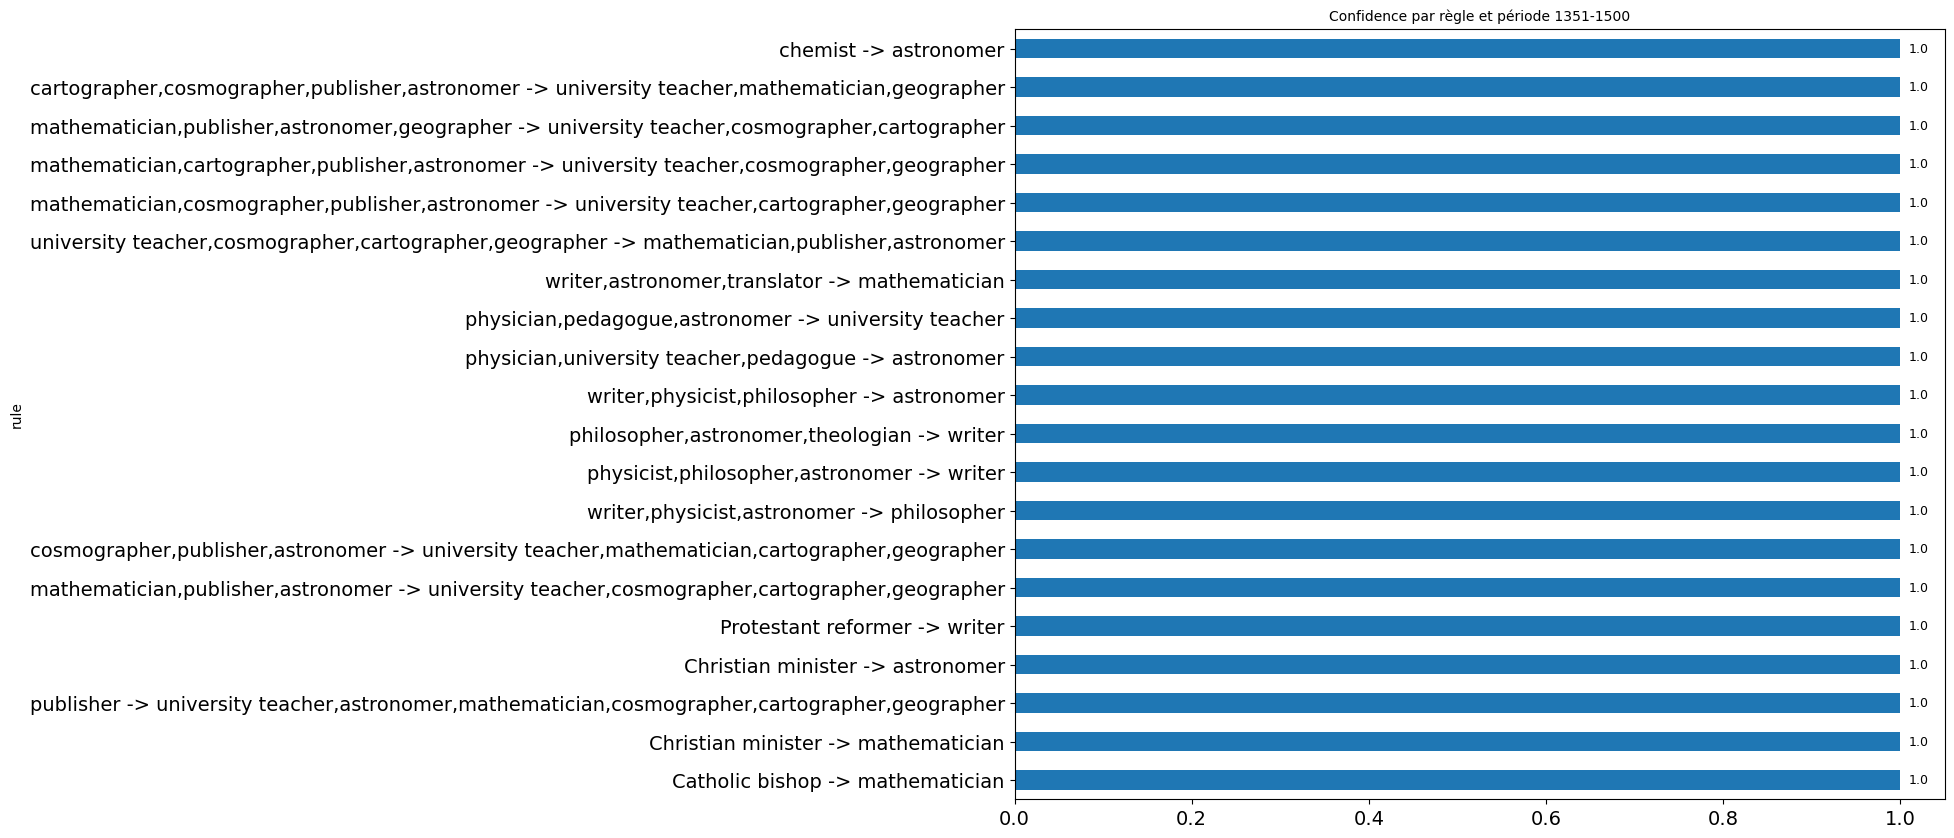

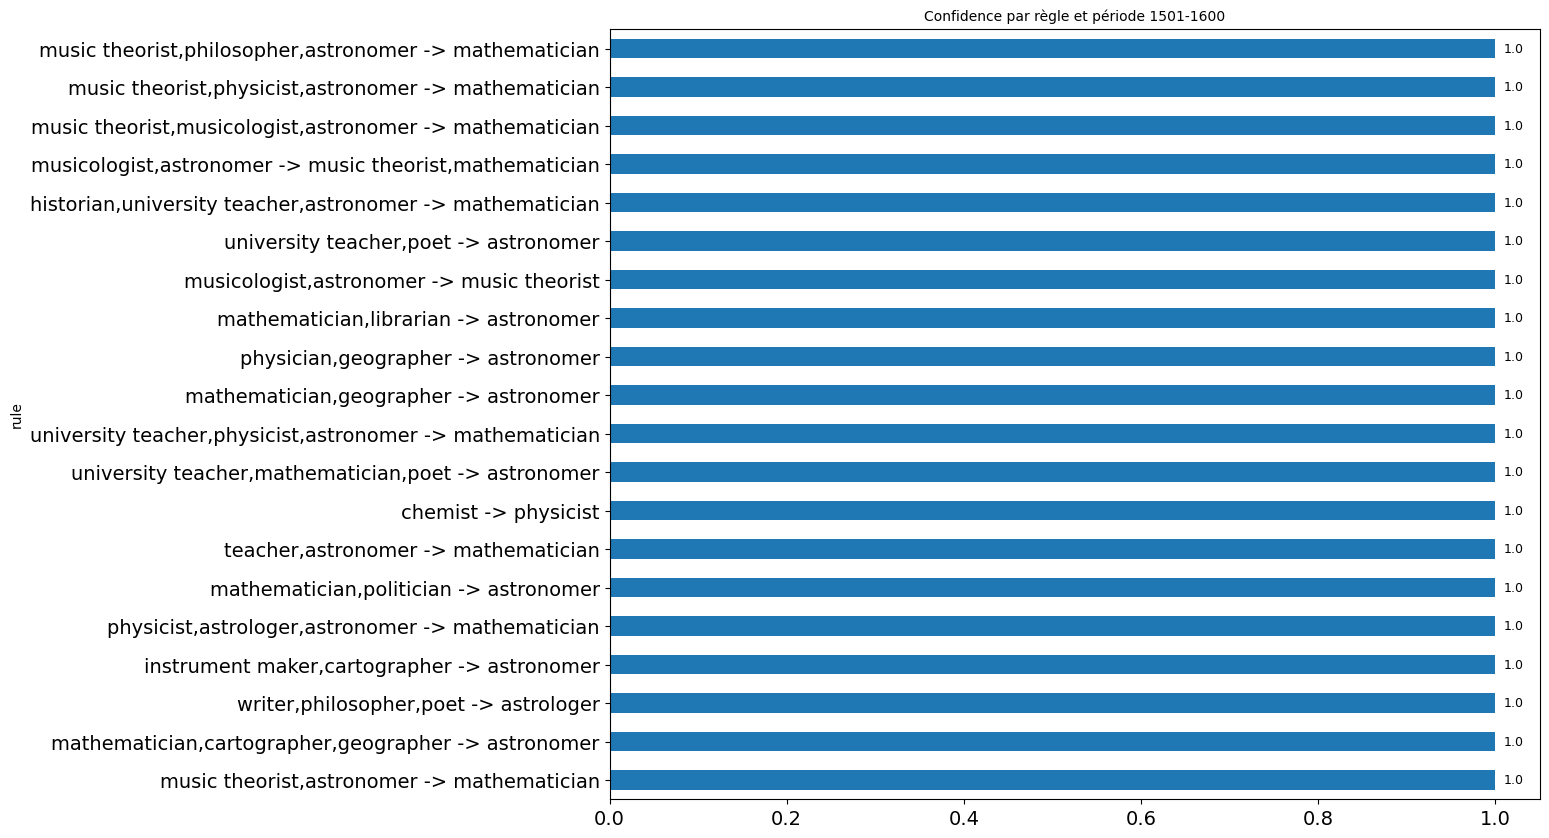

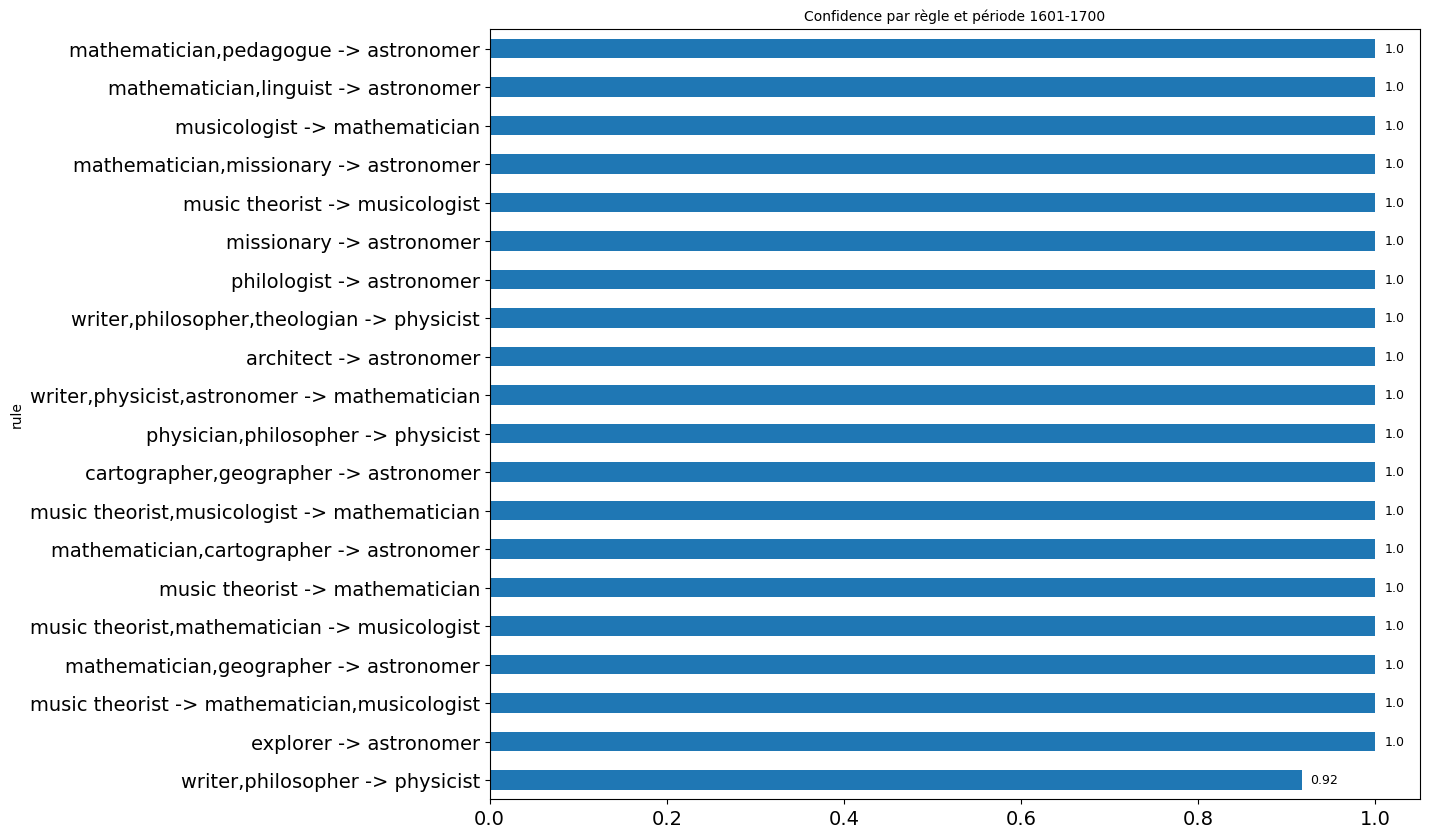

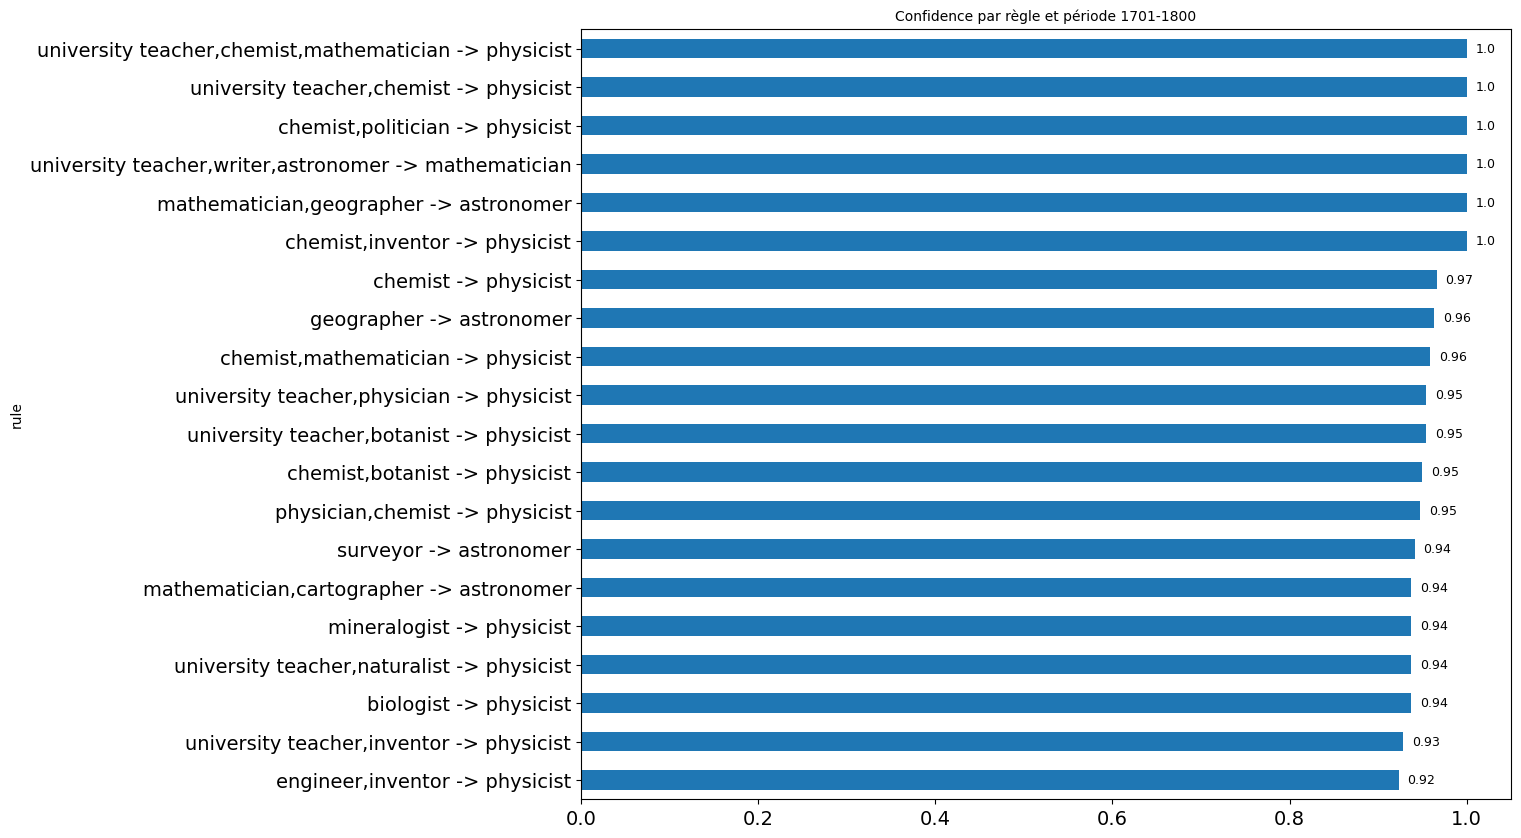

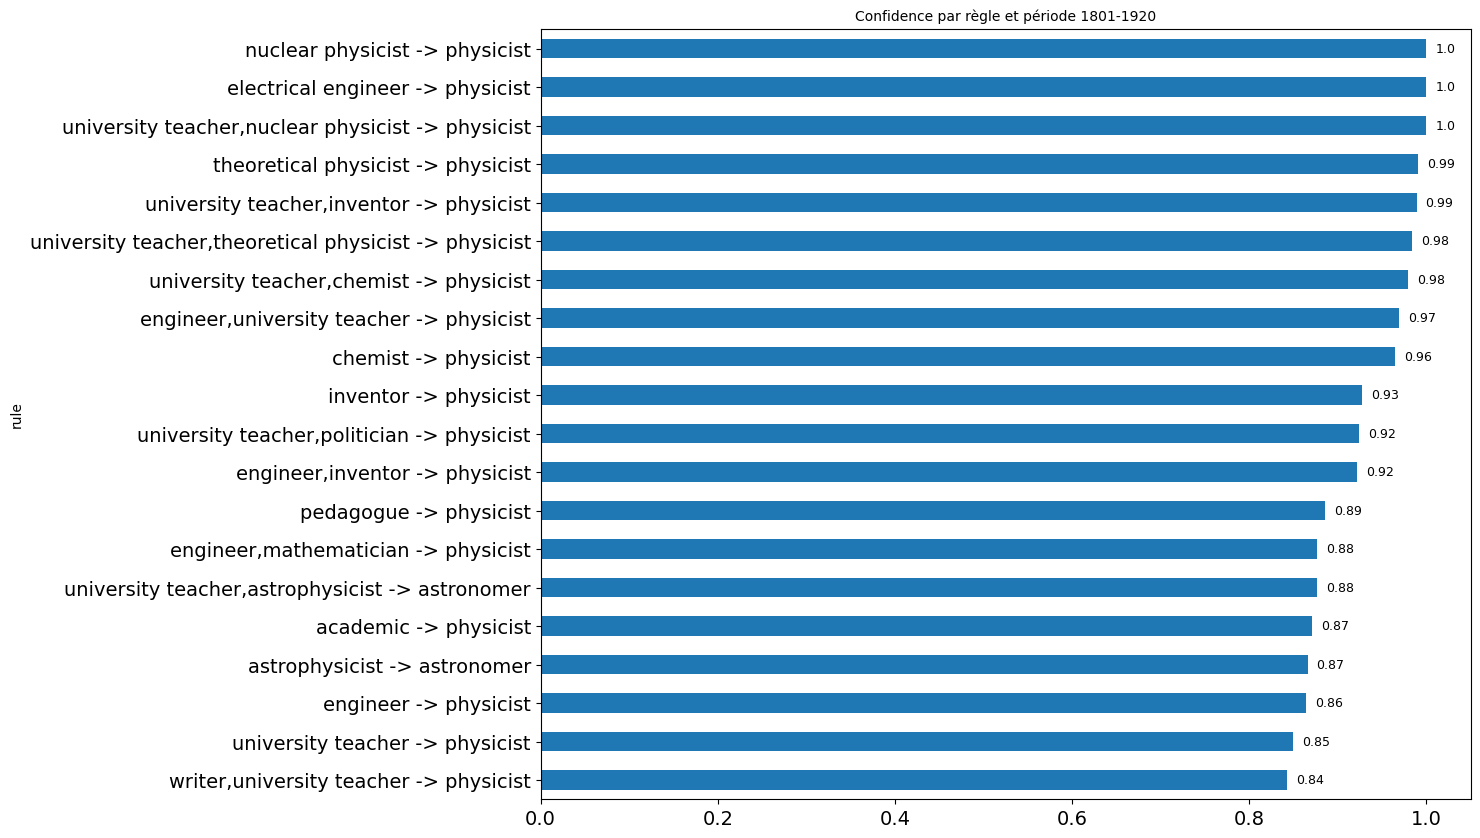

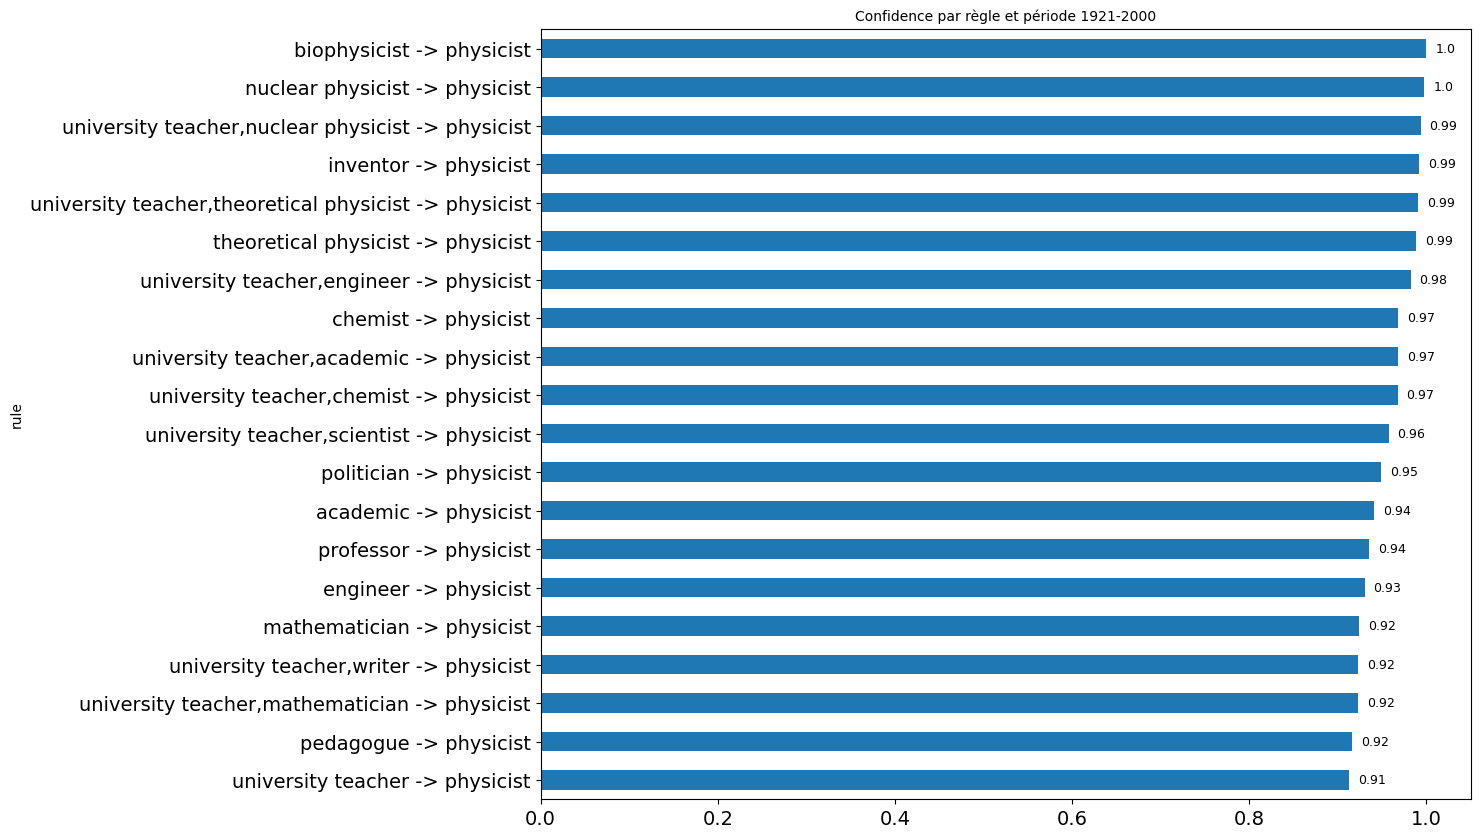

In [150]:
# loop through tickers and axes
for ticker in tickers:
    
    df = combinaisons_per[combinaisons_per["periodes"] == ticker].sort_values(by='effectif', ascending=False)[:10][['occupations','effectif']]

    dd = df_p[(df_p['periodes']==ticker) & (df_p['length_l_occ']> 1)]
    te = TransactionEncoder()
    ## on cherche les combinaisons, on exclut donc les trois disciplines seules
    te_ary = te.fit_transform(dd['l_occupations'])
    data_df=pd.DataFrame(te_ary, columns=te.columns_)
    frequent_itemsets = apriori(data_df, min_support= 0.0099, use_colnames=True)
    frequent_itemsets['eff'] = frequent_itemsets['itemsets'].apply(lambda x : len(x))
    frequent_itemsets['l_itemsets'] = frequent_itemsets['itemsets'].apply(lambda x : sorted(list(x)))
    ar = association_rules(frequent_itemsets, min_threshold=0.0 \
                 ).drop('conviction', axis=1).reset_index(drop=True)
    cc = ar.sort_values(by='confidence', ascending=False).head(20)
    cc['rule'] = cc.apply(lambda x : ','.join(list(x['antecedents'])) + ' -> '+ ','.join(list(x['consequents'])), axis=1 )
    df = cc[['rule', 'confidence']].sort_values(by='confidence', ascending=False)

    ax=df.sort_values(by='confidence', ascending=True).plot(x='rule', y='confidence', 
                    kind='barh', fontsize=14, figsize=(12,10)) # ,rot=5


    x = df.sort_values(by='confidence', ascending=True)['confidence'].to_list()
    for i, v in enumerate(x):
        ax.text(v + 0.01, i, str(round(v,2)), color='black', fontsize=9, verticalalignment='center')  



    # chart formatting
    ax.set_title(ticker.upper(), fontsize=10)
    ax.get_legend().remove()
    ax.set_xlabel("")


    #plt.ylabel('Effectif')
    #plt.xlabel('Professions')
    plt.title('Confidence par règle et période ' + ticker, fontsize=10 )
    
plt.show()


## Filtre sur les professions

In [61]:
def filter_occupation( x, list ):
    for e in list:
        if e in x.l_occupations:
            a = True
            break
        else:
            a = False
    return a           

In [62]:
### Les professions les plus fréquentes
ll = [e.split('; ') for e in dfr['labels_occ'][dfr['nombre_occ'] > 99].to_list()]
lpf= []
for e in ll:
    lpf = lpf + e

lpf = list(set(lpf))
print(len(lpf))

754


In [63]:
### Les professions souhaitées
lpf=['non-fiction writer','photographer']
lpf=['astrologer']

In [64]:
filtered_df_p = df_p[df_p.apply(lambda x: filter_occupation(x, lpf), axis=1)]
print(len(filtered_df_p))
filtered_df_p.head()

909


,person_label,birthYear,l_occupations,gender,periodes
person_uri,,,,,
http://www.wikidata.org/entity/Q100234964,Alessandro De Angelis,1559,"[astrologer, theologian]",M,1501-1600
http://www.wikidata.org/entity/Q100708787,Patric Walker,1931,"[astrologer, writer]",M,1921-2000
http://www.wikidata.org/entity/Q100715,Alfons Rosenberg,1902,"[astrologer, writer]",M,1801-1920
http://www.wikidata.org/entity/Q10272446,Emma Costet de Mascheville,1903,[astrologer],F,1801-1920
http://www.wikidata.org/entity/Q1029283,David Pingree,1933,"[astrologer, historian of mathematics, mathema...",M,1921-2000


In [73]:
### Ajouter des filtres supplémentaires
l = filtered_df_p['l_occupations'].to_list()
len(l), l[:3]

(909,
 [['astrologer', 'theologian'],
  ['astrologer', 'writer'],
  ['astrologer', 'writer']])

In [74]:
### toutes les nationalités (même multiples)
lb = [sorted([i.strip().replace(' ', '_') for i in e]) for e in l]
lb[:3]

[['astrologer', 'theologian'],
 ['astrologer', 'writer'],
 ['astrologer', 'writer']]

In [75]:
te = TransactionEncoder()
te_ary = te.fit_transform(lb)
data_df=pd.DataFrame(te_ary, columns=te.columns_)
data_df.head()

,Anglican_priest,Blavatskian_theosophy,Buddhologist,Catholic_bishop,Catholic_priest,Catholic_theologian,Christian_minister,Christian_mystic,Esperantist,Latin_Catholic_priest,...,translator,typographer,university_teacher,vedette,violinist,visual_artist,voice_actor,writer,yogi,zoologist
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


In [91]:
frequent_itemsets = apriori(data_df, min_support= 0.01, use_colnames=True)
frequent_itemsets['eff'] = frequent_itemsets['itemsets'].apply(lambda x : len(x))
frequent_itemsets['l_itemsets'] = frequent_itemsets['itemsets'].apply(lambda x : sorted(list(x)))
show(frequent_itemsets.sort_values(by='support', ascending=False),
    scrollY="200px", scrollCollapse=True, paging=False) 

In [93]:
ar = association_rules(frequent_itemsets, metric="support",
                  min_threshold=0.001).drop('conviction', axis=1).reset_index(drop=True)

print(len(ar))
ar.head()

454


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,zhangs_metric
0,(astrologer),(actor),1.000000,0.024202,0.024202,0.024202,1.0,0.0,0.0
1,(actor),(astrologer),0.024202,1.000000,0.024202,1.000000,1.0,0.0,0.0
2,(astrologer),(alchemist),1.000000,0.011001,0.011001,0.011001,1.0,0.0,0.0
3,(alchemist),(astrologer),0.011001,1.000000,0.011001,1.000000,1.0,0.0,0.0
4,(astronomer),(astrologer),0.154015,1.000000,0.154015,1.000000,1.0,0.0,0.0


In [94]:
show(ar.sort_values(by='lift', ascending=False),
    scrollY="200px", scrollCollapse=True, paging=False) 